In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt 

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


data preparation : transformer and loader 

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
train_dataset = datasets.Flowers102(root='flowers', split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root='flowers', split='test', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is available:{device}")

Device is available:cpu


In [5]:
model=Autoencoder().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [6]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 5 == 0:
        print(f"epoch: [{epoch + 1}/{num_epochs}], loss: {epoch_loss:.4f}")


epoch: [5/50], loss: 0.0246
epoch: [10/50], loss: 0.0141
epoch: [15/50], loss: 0.0115
epoch: [20/50], loss: 0.0076
epoch: [25/50], loss: 0.0067
epoch: [30/50], loss: 0.0063
epoch: [35/50], loss: 0.0060
epoch: [40/50], loss: 0.0059
epoch: [45/50], loss: 0.0057
epoch: [50/50], loss: 0.0055


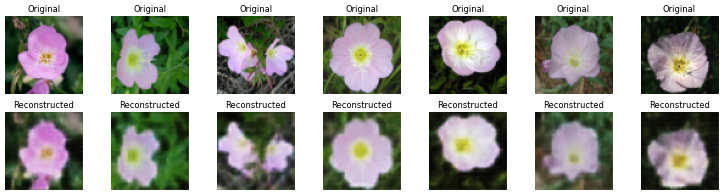

In [7]:
torch.save(model.state_dict(),'conv_autoencoder.pth')
model.eval()

with torch.no_grad():
    for data,_ in test_loader:
        data=data.to(device)
        recon=model(data)
        break 

    fig,ax=plt.subplots(2,7,figsize=(15,4), dpi=50)
    for i in range(7):
        ax[0, i].imshow(data[i].cpu().permute(1,2,0).numpy())
        ax[0, i].set_title('Original')
        ax[0, i].axis('off')

        ax[1, i].imshow(recon[i].cpu().permute(1,2,0).numpy())
        ax[1, i].set_title('Reconstructed')
        ax[1, i].axis('off')

    plt.tight_layout()
    plt.show()
